In [115]:
#Importing Required Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer

#for Spliting Data and Hyperparameter Tuning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler

#Importing Machine Learning Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier
    
#Bagging Algo
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier


#To tranform data
from sklearn import preprocessing

#statistical Tools
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

#Setting Format
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings("ignore")

In [94]:
df_ori=pd.read_csv('data/car_loan.csv')
df=df_ori.copy()

In [95]:
df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [96]:
#missing value
df['Employment.Type'].unique()
df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')

In [97]:
#combine cols
df['total_overdue_accts'] = df['PRI.OVERDUE.ACCTS']+df['SEC.OVERDUE.ACCTS']
df['total_current_balance'] = df['PRI.CURRENT.BALANCE']+df['SEC.CURRENT.BALANCE']
df['total_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT']+df['SEC.SANCTIONED.AMOUNT']
df['total_EMI'] = df['PRIMARY.INSTAL.AMT']+df['SEC.INSTAL.AMT']
df['total_no_of_accts']=df['PRI.NO.OF.ACCTS']+df['SEC.NO.OF.ACCTS']
df['total_active_accts']=df['PRI.ACTIVE.ACCTS']+df['SEC.ACTIVE.ACCTS']
df.drop([ 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
   'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
   'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
   'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT'],axis=1,inplace=True)

In [99]:
#ordinal cols
df['PERFORM_CNS.SCORE.DESCRIPTION']=df['PERFORM_CNS.SCORE.DESCRIPTION'].str[0].map(
lambda x:'Very_low_risk'
    if x in ['A','B''C','D']
    else('Lowe_risk' if x in ['E','F','G']
    else('Medium_risk'if x in ['H','I']
    else('High_risk'if x in ['J','K'] 
    else('Very_high_risk'if x in ['I','M'] else 'N')))))

In [100]:
#drop unrelated cols
X_drop=['UniqueID','branch_id','supplier_id', 'manufacturer_id','State_ID', 'Employee_code_ID']
df.drop(X_drop,axis=1,inplace=True)

In [101]:
#date to age
def age(date):
    yr = int(date[-2:])
    if yr >=0 and yr < 20:
        return yr + 2000
    else:
         return yr + 1900
df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df.drop(['DisbursalDate','Date.of.Birth'],axis=1,inplace=True)

In [102]:
#format month cols
def change_col_month(col):
    year = int(col.split()[0].replace('yrs',''))
    month = int(col.split()[1].replace('mon',''))
    return year*12+month
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(change_col_month)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(change_col_month)

In [103]:
y = df['loan_default']
X = df.loc[:, df.columns != 'loan_default']

In [107]:
random_state=42
X_other, X_test, y_other, y_test = train_test_split(X,y,stratify=y,test_size = 0.2,random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_other,y_other,stratify=y_other,test_size = 0.25,random_state=random_state)


In [119]:
X_catCol=['Employment.Type']
X_order=['PERFORM_CNS.SCORE.DESCRIPTION']
X_discret=['total_overdue_accts', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','Age']
X_conti=['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE', 
         'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES','total_overdue_accts', 'total_current_balance',
       'total_sanctioned_amount', 'total_EMI', 'total_no_of_accts','total_active_accts']
ordinal_cats=[['N', 'Very_low_risk','Lowe_risk','Medium_risk', 'High_risk','Very_high_risk']]

In [120]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), X_order),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), X_catCol),
        ('std', StandardScaler(), X_conti),
        ('minmax', MinMaxScaler(), X_discret)])
clf = Pipeline(steps=[('preprocessor', preprocessor)]) 
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

In [4]:
def roc_curve_f(y_test,y_test_pred):
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)*100
    
    #ROC Plot
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [113]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
def MLpipe_KSFold_auc(X, y, preprocessor, ML_algo, param_grid): 
    nr_state=5
    final_models=[]
    best_models_scores = []
    test_scores = np.zeros(nr_state)
    for i in range(nr_state):
        X_other, X_test, y_other, y_test = train_test_split(X, y, stratify=y, test_size=0.2,random_state=42*i)
        kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42*i)
        pipe = make_pipeline(preprocessor,ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'roc_auc',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        grid.fit(X_other, y_other)
        final_models.append(grid)
        y_test_pred = final_models[-1].predict(X_test)
        best_models_scores.append([grid.best_params_,f1_score(y_test,y_test_pred),roc_auc_score(y_test,y_test_pred)])
    return best_models_scores[np.argmax(best_models_score,axis=1)]

In [114]:
f_base=[]
for i in range(5):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2,random_state=11*i)
    y1=[i for i in y_test if i ==1]
    p_base=len(y1)/len(y_test)
    f_base.append((2*p_base)/(p_base+1))

K Nearest Neighbour
accuracy_score 73.47229450272536
precision_score 74.0996685207034
recall_score 72.21309680245291
f1_score 73.14421983750658
roc_auc_score 73.47295015513163
confusion_matrix
       0      1
0  13635   4610
1   5075  13189


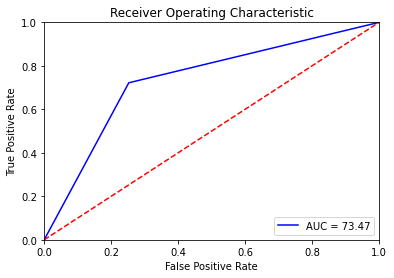

In [35]:
#knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_knn = {'kneighborsclassifier__n_neighbors': [5,10,50,100,200],
            'kneighborsclassifier__weights':['uniform','distance']}
best_models_knn=MLpipe_KSFold_auc(X,y,preprocessor,knn,param_knn)
best_models_knn[np.argmax(np.array(best_models_knn)[:,1])]

Logistic Regression
accuracy_score 0.6842970226519488
precision_score 0.7006312529776084
recall_score 0.6441633815155497
f1_score 0.6712117754450023
roc_auc_score 0.684317919861639
confusion_matrix
       0      1
0  13218   5027
1   6499  11765


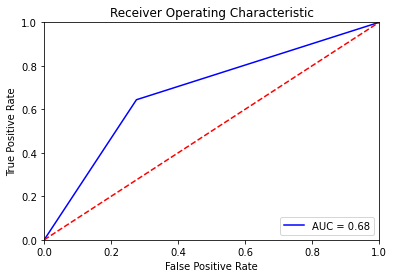

In [63]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression(penalty='l2',random_state=0,max_iter=100000000)
lgr_param={'logisticregression__C':  [1e4,1e3,1e2,1.0, 0.1, 0.01]}
best_models_lgr=MLpipe_KSFold_auc(X,y,preprocessor,lgr,lgr_param)
best_models_lgr[np.argmax(np.array(best_models_lgr)[:,1])]

Decision Tree Classifier
accuracy_score 75.65805691747241
precision_score 79.10484822149108
recall_score 69.77113447218572
f1_score 74.14540482355336
roc_auc_score 75.66112218265356
confusion_matrix
       0      1
0  14879   3366
1   5521  12743


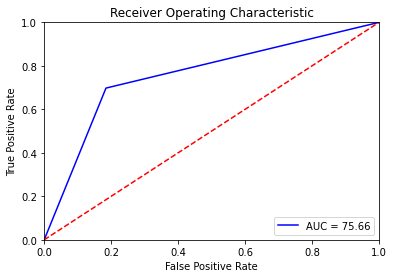

In [40]:
dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=25, min_samples_split=4,
                            min_samples_leaf=2)

train_model(dtc, 'Decision Tree Classifier')

Random Forest Classifier
[0.04196719 0.01829273 0.04743838 0.01674616 0.07386118 0.
 0.06946935 0.01721904 0.07725055 0.02153791 0.00194154 0.07515072
 0.08100353 0.05802524 0.03736224 0.02382052 0.02806796 0.04687329
 0.04087906 0.03073667 0.06225326 0.01303319 0.01551474 0.01431467
 0.05874592 0.02849495]
accuracy_score 0.7773151825577255
precision_score 0.8364095073695392
recall_score 0.689772229522558
f1_score 0.7560463301926423
roc_auc_score 0.7773607653504815
confusion_matrix
       0      1
0  15781   2464
1   5666  12598


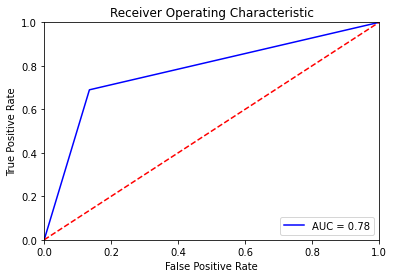

In [43]:
#random forest
rfc_param = { 
    'randomforestclassifier__n_estimators': [50, 100],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth' : [4,5,6]
}
rfc =RandomForestClassifier(random_state=0)
best_models_rfc=MLpipe_KSFold_auc(X,y,preprocessor,rfc,rfc_param)
best_models_rfc[np.argmax(np.array(best_models_rfc)[:,1])]

In [34]:
#xgboost
from  xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42,early_stopping_rounds=2,objective= 'binary:logistic')
xgbc_param = {
              'xgbclassifier__max_depth' : [4,5,6],
              'xgbclassifier__n_estimators' : [100,150],
              'xgbclassifier__learning_rate' : [0.1,0.5,0.8],
                'xgbclassifier__min_child_weight' : [1,3,5],
                'xgbclassifier__subsample':[0.6,0.8,1]
             }
best_models_xgbc=MLpipe_KSFold_auc(X,y,preprocessor,xgbc,xgbc_param)
best_models_xgbc[np.argmax(np.array(best_models_xgbc)[:,1])]

[15:52:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
xgb.get_booster().feature_names = ['disbursed_amount', 'asset_cost', 'ltv', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'CNS_SCORE_DESCRIPTION',
       'NO_OF_ACCTS', 'ACTIVE_ACCTS', 'OVERDUE_ACCTS', 'CURRENT_BALANCE',
       'SANCTIONED_AMOUNT', 'DISBURSED_AMOUNT', 'INSTAL_AMT', 'Age']

Text(0.5, 1.0, 'Feature importance(weight)')

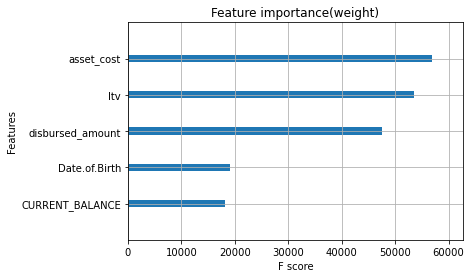

In [65]:
from xgboost import plot_importance
importance=xgb.get_booster().get_score(importance_type= 'weight')
ax1=plot_importance(importance, max_num_features=5, importance_type='weight', show_values=False)
ax1.set_title('Feature importance(weight)')

Text(0.5, 1.0, 'Feature importance(gain)')

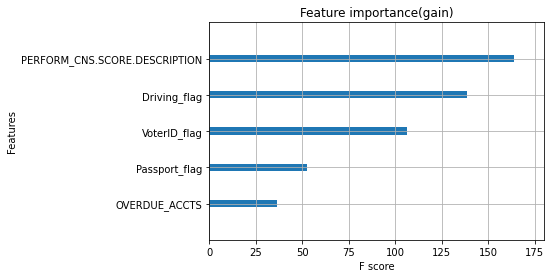

In [66]:
importance=xgb.get_booster().get_score(importance_type= 'gain')
ax2=plot_importance(importance, max_num_features=5, importance_type='gain', show_values=False)
ax2.set_title('Feature importance(gain)')

Text(0.5, 1.0, 'Feature importance(cover)')

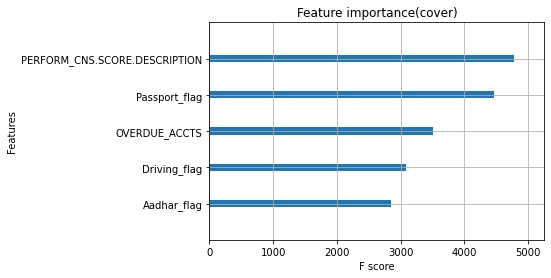

In [67]:
importance=xgb.get_booster().get_score(importance_type= 'cover')
ax3=plot_importance(importance, max_num_features=5, importance_type='cover', show_values=False)
ax3.set_title('Feature importance(cover)')

In [45]:
import pandas as pd
import numpy as np
import shap
from sklearn import tree
warnings.filterwarnings('ignore')

In [46]:
shap.initjs()

In [47]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test)

In [77]:
i =1000
feature_names=['disbursed_amount', 'asset_cost', 'ltv', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'CNS_SCORE_DESCRIPTION',
       'NO_OF_ACCTS', 'ACTIVE_ACCTS', 'OVERDUE_ACCTS', 'CURRENT_BALANCE',
       'SANCTIONED_AMOUNT', 'DISBURSED_AMOUNT', 'INSTAL_AMT', 'Age']
shap.force_plot(explainer.expected_value, shap_values[i], features=X[i], feature_names=feature_names)

XGBClassifier
[14:13:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
feature_importances
[0.00330492 0.0028168  0.00394274 0.01584101 0.02197301 0.
 0.04480579 0.0291759  0.14003477 0.20670159 0.08922039 0.00782542
 0.24555716 0.02408763 0.03815025 0.00335178 0.00325188 0.01371774
 0.01180131 0.00921357 0.04561974 0.00313763 0.00377738 0.00310193
 0.00926214 0.02032745]
weight
{'f12': 608, 'f4': 4872, 'f6': 1308, 'f8': 1114, 'f9': 290, 'f7': 955, 'f10': 90, 'f3': 18735, 'f0': 48578, 'f22': 11667, 'f2': 54729, 'f24': 18143, 'f20': 1743, 'f15': 12170, 'f1': 58319, 'f25': 15340, 'f18': 7644, 'f11': 14849, 'f19': 3836, 'f17': 4643, 'f21': 18063, 'f23': 9044, 'f16': 13558, 'f13': 3001, 'f14

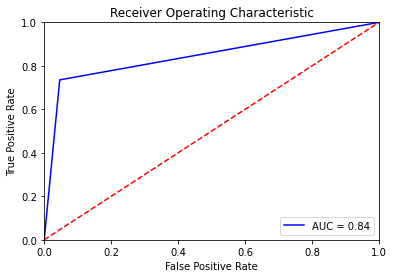

In [85]:
#xgboost
from  xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42,early_stopping_rounds=2,objective= 'binary:logistic')
xgbc_param = {
              'xgbclassifier__max_depth' : [4,5,6],
              'xgbclassifier__n_estimators' : [100,150],
              'xgbclassifier__learning_rate' : [0.1,0.5,0.8],
                'xgbclassifier__min_child_weight' : [1,3,5],
                'xgbclassifier__subsample':[0.6,0.8,1]
             }
best_models_xgbc=MLpipe_KSFold_auc(X,y,preprocessor,xgbc,xgbc_param)
best_models_xgbc[np.argmax(np.array(best_models_xgbc)[:,1])]

AdaBoostClassifier
accuracy_score 74.90207893943959
precision_score 79.05254421247527
recall_score 67.79456855015331
f1_score 72.99201226162056
roc_auc_score 74.90577975328986
confusion_matrix
       0      1
0  14964   3281
1   5882  12382


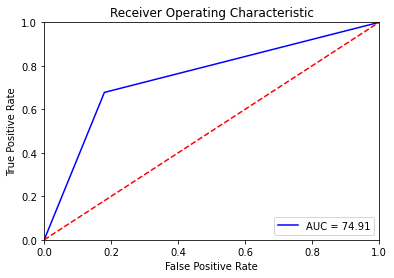

In [39]:
ada = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)

train_model(ada, 'AdaBoostClassifier')

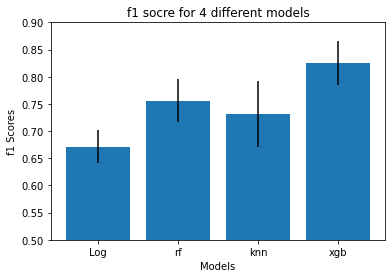

In [81]:
models=['Log','rf','knn','xgb'] 
plt.bar(models, train_mean,yerr=train_std)

plt.ylabel('f1 Scores')
plt.xlabel('Models')
plt.title('f1 socre for 4 different models')

#plt.xticks(ind + width / 2, max_depth)
plt.ylim([0.5,0.9])
#plt.legend(loc='best')
plt.show()

In [85]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = ['Not Default','Defaulter']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

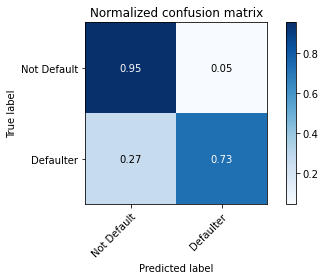

In [86]:
plot_confusion_matrix(y_test,pred,[0,1], normalize=True, title=None, cmap=plt.cm.Blues)